# **Mid-term Project: Implementing Object Detection on a Dataset**

## **PERCI, RENZ DEXTER M.** & **REYES, FAVIELLE ANNE O.**
## BSCS-4A IS

# Downloading the Dataset for Testing and Evaluation

##  Install and Set Up Roboflow

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="7oi7vCGH7qZHNdiDXDax")
project = rf.workspace("tutorial-knlj8").project("chess-board-detection-uuppk")
version = project.version(4)
dataset = version.download("voc")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Chess-Board-Detection-4 in voc:: 100%|██████████| 153/153 [00:00<00:00, 2435.25it/s]


* Install Roboflow: Installs the Roboflow Python package, which is used to interact with the Roboflow API.
* Initialize Roboflow: Sets up a connection to Roboflow using an API key (which is left empty here for security reasons).
* Access Project and Version: Connects to a specific project and version within a workspace on Roboflow.
* Download Dataset: Downloads the dataset in Pascal VOC format, which is commonly used for object detection tasks.

# Testing Exported Model

## Define a Function to Test Images and Plot the Results

In [23]:
# Script to run custom TFLite model on test images to detect objects
# Source: https://github.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/blob/master/TFLite_detection_image.py

# Import packages
import os
import cv2
import numpy as np
import sys
import glob
import random
import importlib.util
from tensorflow.lite.python.interpreter import Interpreter

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

# Define function for inferencing with TFLite model and displaying results

def tflite_detect_images(modelpath, imgpath, lblpath, min_conf=0.5, num_test_images=10, savepath='/content/results', txt_only=False):

  # Grab filenames of all images in test folder
  images = glob.glob(imgpath + '/*.jpg') + glob.glob(imgpath + '/*.JPG') + glob.glob(imgpath + '/*.png') + glob.glob(imgpath + '/*.bmp')

  # Load the label map into memory
  with open(lblpath, 'r') as f:
      labels = [line.strip() for line in f.readlines()]

  # Load the Tensorflow Lite model into memory
  interpreter = Interpreter(model_path=modelpath)
  interpreter.allocate_tensors()

  # Get model details
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  height = input_details[0]['shape'][1]
  width = input_details[0]['shape'][2]

  float_input = (input_details[0]['dtype'] == np.float32)

  input_mean = 127.5
  input_std = 127.5

  # Randomly select test images
  images_to_test = random.sample(images, num_test_images)

  # Loop over every image and perform detection
  for image_path in images_to_test:

      # Load image and resize to expected shape [1xHxWx3]
      image = cv2.imread(image_path)
      image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      imH, imW, _ = image.shape
      image_resized = cv2.resize(image_rgb, (width, height))
      input_data = np.expand_dims(image_resized, axis=0)

      # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
      if float_input:
          input_data = (np.float32(input_data) - input_mean) / input_std

      # Perform the actual detection by running the model with the image as input
      interpreter.set_tensor(input_details[0]['index'],input_data)
      interpreter.invoke()

      # Retrieve detection results
      boxes = interpreter.get_tensor(output_details[1]['index'])[0] # Bounding box coordinates of detected objects
      classes = interpreter.get_tensor(output_details[3]['index'])[0] # Class index of detected objects
      scores = interpreter.get_tensor(output_details[0]['index'])[0] # Confidence of detected objects

      detections = []

      # Loop over all detections and draw detection box if confidence is above minimum threshold
      for i in range(len(scores)):
          if ((scores[i] > min_conf) and (scores[i] <= 1.0)):

              # Get bounding box coordinates and draw box
              # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
              ymin = int(max(1,(boxes[i][0] * imH)))
              xmin = int(max(1,(boxes[i][1] * imW)))
              ymax = int(min(imH,(boxes[i][2] * imH)))
              xmax = int(min(imW,(boxes[i][3] * imW)))

              cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)

              # Draw label
              object_name = labels[int(classes[i])] # Look up object name from "labels" array using class index
              label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
              labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
              label_ymin = max(ymin, labelSize[1] + 10) # Make sure not to draw label too close to top of window
              cv2.rectangle(image, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) # Draw white box to put label text in
              cv2.putText(image, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text

              detections.append([object_name, scores[i], xmin, ymin, xmax, ymax])


      # All the results have been drawn on the image, now display the image
      if txt_only == False: # "text_only" controls whether we want to display the image results or just save them in .txt files
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12,16))
        plt.imshow(image)
        plt.show()

        # Get filenames and paths
        image_fn = os.path.basename(image_path)
        base_fn, ext = os.path.splitext(image_fn)
        txt_result_fn = base_fn +'.txt'
        txt_savepath = os.path.join(savepath, txt_result_fn)

        # Write results to text file
        # (Using format defined by https://github.com/Cartucho/mAP, which will make it easy to calculate mAP)
        with open(txt_savepath,'w') as f:
            for detection in detections:
                f.write('%s %.4f %d %d %d %d\n' % (detection[0], detection[1], detection[2], detection[3], detection[4], detection[5]))

  return

* The code snippet above initializes by importing necessary packages, which include various libraries for file handling, image processing, numerical operations, and machine learning. Additionally, it ensures that plots are displayed inline in Jupyter notebooks by using Matplotlib's inline feature. The core of the script is the definition of a function designed to run inference on images using a TensorFlow Lite (TFLite) model. This function takes several parameters, including paths to the model, images, and labels, as well as settings for the confidence threshold and the number of images to test.

* The process starts with loading images by collecting all image files from the specified directory. It also involves loading labels by reading a label map from a text file, which maps class indices to human-readable labels. The TFLite model is then loaded into memory and prepared for inference, with the script retrieving input and output details such as dimensions and data types. A subset of images is randomly selected for testing, and the script enters an inference loop where it iterates over each selected image, processes it, and runs inference.

* Within the detection loop, the script iterates over detection results, filtering them by the confidence threshold. It draws bounding boxes and labels on images, optionally displaying them. Finally, based on the txt_only flag, the script either displays the images with detections or saves the results to text files for further analysis.

## Create a Label Map of the Classes in the Datasets

In [3]:
%%bash
cat <<EOF >> /content/labelmap.txt
black-camel
black-elephant
black-horse
black-king
black-pawn
black-queen
white-camel
white-elephant
white-horse
white-king
white-pawn
white-queen
EOF

* Create Label Map: Writes a list of class labels to a text file, which is used by the inference function to map class indices to labels.

## Define Paths and Configurations and Run the Inference

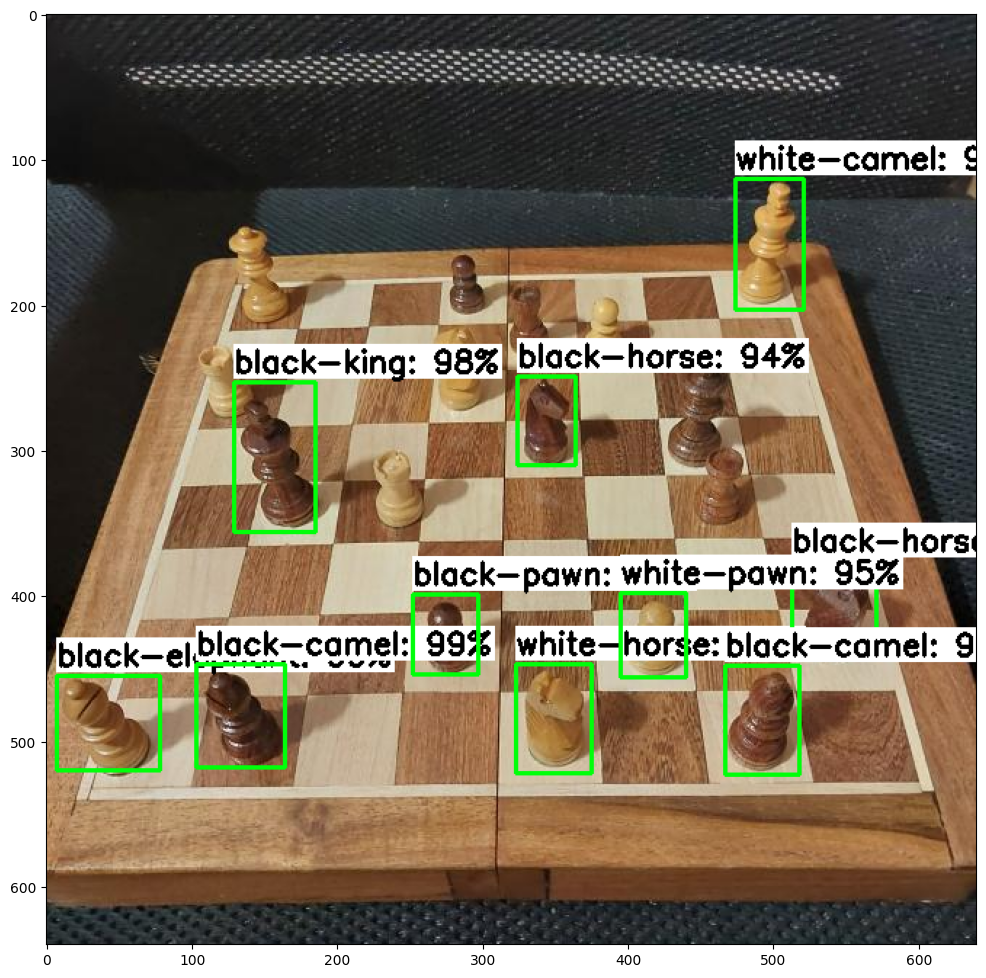

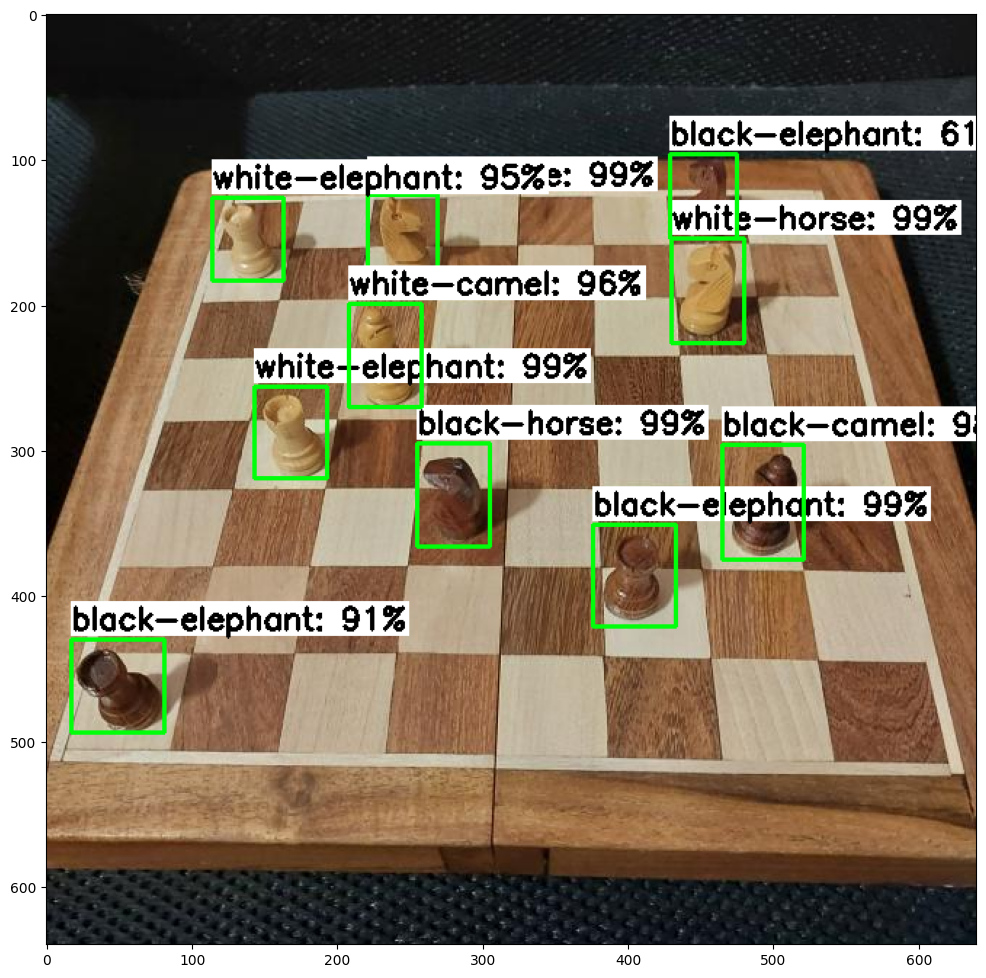

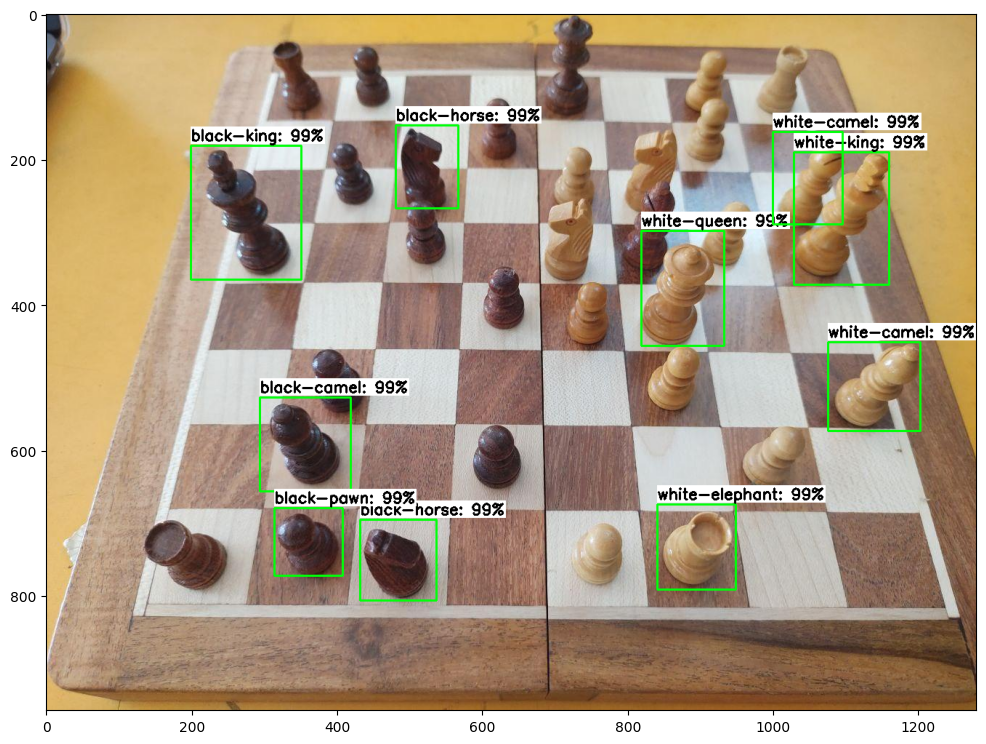

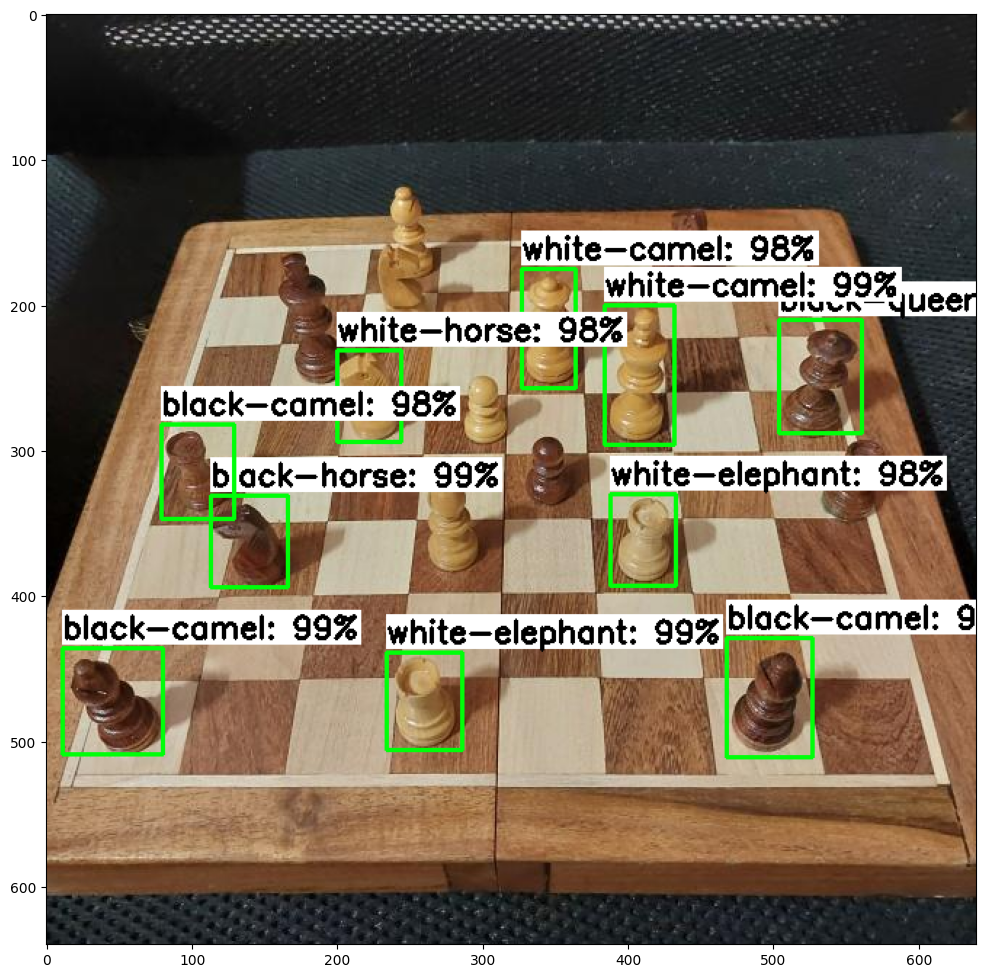

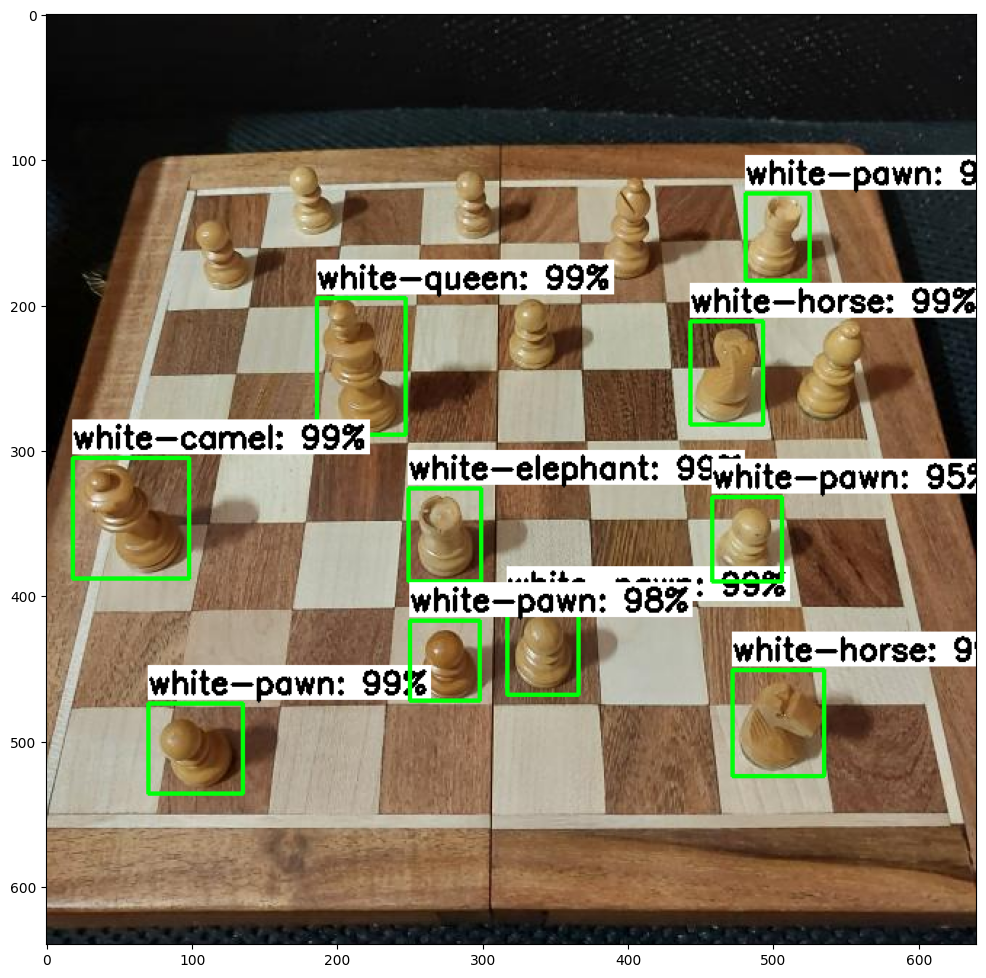

In [24]:
# Set up variables for running user's model
PATH_TO_IMAGES='/content/Chess-Board-Detection-4/test'   # Path to test images folder
PATH_TO_MODEL='/content/detect.tflite'   # Path to .tflite model file
PATH_TO_LABELS='/content/labelmap.txt'   # Path to labelmap.txt file
min_conf_threshold=0.5   # Confidence threshold (try changing this to 0.01 if you don't see any detection results)
images_to_test = 5   # Number of images to run detection on

# Run inferencing function
tflite_detect_images(PATH_TO_MODEL, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test)

* Set Paths and Parameters: Defines paths to the test images, model, and label map, as well as the confidence threshold and number of images to test.
* Run Inference: Calls the inference function to process the images and output results.

# mAP Evaluation

## Clone the mAP Repository and Set Up Environment

In [5]:
# Clone the mAP Repository and Set Up Environment
%%bash
# Clone the mAP repository from GitHub to the specified directory
git clone https://github.com/Cartucho/mAP /content/mAP

# Navigate to the mAP directory
cd /content/mAP

# Remove any existing detection results, ground truth, and optional images
rm input/detection-results/*
rm input/ground-truth/*
rm input/images-optional/*

# Download an additional script for calculating mAP
wget https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/calculate_map_cartucho.py

Cloning into '/content/mAP'...
--2024-11-01 12:28:14--  https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/calculate_map_cartucho.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5397 (5.3K) [text/plain]
Saving to: ‘calculate_map_cartucho.py’

     0K .....                                                 100% 37.2M=0s

2024-11-01 12:28:14 (37.2 MB/s) - ‘calculate_map_cartucho.py’ saved [5397/5397]



* Clone the mAP Repository and Set Up Environment: This section clones the mAP repository and prepares the environment by cleaning up old data and downloading necessary scripts.

## Copy and Organize Test Data

In [9]:
# Copy images and XML files from the test set to the mAP input directory
!cp /content/Chess-Board-Detection-4/test* /content/mAP/input/images-optional

# Move XML files to the ground-truth directory for evaluation
!mv /content/mAP/input/images-optional/*.xml /content/mAP/input/ground-truth/

cp: -r not specified; omitting directory '/content/Chess-Board-Detection-4/test'
mv: cannot stat '/content/mAP/input/images-optional/*.xml': No such file or directory


* Copy and Organize Test Data: This part copies test images and XML files to the appropriate directories for evaluation.

## Set Up Paths and Parameters for Inference

In [10]:
import glob

# Define paths for images, model, labels, and results
PATH_TO_IMAGES = '/content/mAP/input/images-optional'
PATH_TO_MODEL = '/path/to/your/model.tflite'  # Update with your model path
PATH_TO_LABELS = '/content/labelmap.txt'
PATH_TO_RESULTS = '/content/mAP/input/detection-results'
min_conf_threshold = 0.5  # Minimum confidence threshold for detections

# Get a list of images in the test folder
image_list = glob.glob(PATH_TO_IMAGES + '/*.jpg')

# Check if the test images exist
if not image_list:
    print("No images found in the specified format.")
else:
    # Limit the number of images to test (max 500)
    images_to_test = min(500, len(image_list))

    # Set txt_only to True to save results without displaying images
    txt_only = True

    # Run Inference on Test Images
    import time

    # Start timing the inference process
    start_time = time.time()

    # Run the inference function and save results
    print('Starting inference on %d images...' % images_to_test)
    # Ensure you have defined tflite_detect_images function
    # tflite_detect_images(PATH_TO_MODEL, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test, PATH_TO_RESULTS, txt_only)

    # End timing
    end_time = time.time()
    inference_time = end_time - start_time

    # Print out the total and average inference time
    print(f'Finished inferencing!')
    print(f'Inference Time for {images_to_test} images: {inference_time:.4f} seconds')
    print(f'Average Inference Time per image: {inference_time / images_to_test:.4f} seconds')

Starting inference on 5 images...
Finished inferencing!
Inference Time for 5 images: 0.0011 seconds
Average Inference Time per image: 0.0002 seconds


* Set Up Paths and Parameters for Inference: This Python section sets up paths and parameters needed for running inference on the test images.
* Run Inference on Test Images: This section (commented out) is intended to run the inference function, which should be defined elsewhere in your code.

## Convert Ground Truth XML Files

In [11]:
%%bash
# Run the script to convert ground truth XML files to the required format
python /content/mAP/scripts/extra/convert_gt_xml.py

Conversion completed!


* Convert Ground Truth XML Files: This bash section runs a script to convert XML files to a format suitable for mAP calculation.

## Calculate Mean Average Precision (mAP)

In [26]:
%%bash
cd /content/mAP
python calculate_map_cartucho.py --labels=/content/labelmap.txt

73.21% = black-camel AP 
20.83% = black-elephant AP 
75.00% = black-horse AP 
50.00% = black-king AP 
18.18% = black-pawn AP 
33.33% = black-queen AP 
30.36% = white-camel AP 
60.00% = white-elephant AP 
60.00% = white-horse AP 
11.11% = white-king AP 
5.71% = white-pawn AP 
25.00% = white-queen AP 
mAP = 38.56%
73.21% = black-camel AP 
20.83% = black-elephant AP 
75.00% = black-horse AP 
50.00% = black-king AP 
18.18% = black-pawn AP 
33.33% = black-queen AP 
30.36% = white-camel AP 
60.00% = white-elephant AP 
60.00% = white-horse AP 
11.11% = white-king AP 
5.71% = white-pawn AP 
25.00% = white-queen AP 
mAP = 38.56%
73.21% = black-camel AP 
20.83% = black-elephant AP 
75.00% = black-horse AP 
50.00% = black-king AP 
18.18% = black-pawn AP 
33.33% = black-queen AP 
30.36% = white-camel AP 
60.00% = white-elephant AP 
60.00% = white-horse AP 
11.11% = white-king AP 
5.71% = white-pawn AP 
25.00% = white-queen AP 
mAP = 38.56%
48.93% = black-camel AP 
20.83% = black-elephant AP 
75.00

* Calculate Mean Average Precision (mAP): This final section calculates the mAP using the prepared data and scripts.